In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import math

# Load the data
meth = pd.read_csv('meth.csv')

# Normalize the data
scaler = StandardScaler()
meth_scaled = scaler.fit_transform(meth)

# Define the autoencoder model
def create_denoising_autoencoder(input_dim, regularization=1e-6, dropout_rate=0.3, noise_factor=0.3):
    input_layer = Input(shape=(input_dim,))
    
    # Add Gaussian Noise for denoising
    noisy_input = GaussianNoise(noise_factor)(input_layer)
    
    # Encoder
    encoded = Dense(512, activation='relu', kernel_regularizer=l2(regularization))(noisy_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = Dense(64, activation='relu', activity_regularizer=l1(1e-5))(encoded)  # Sparse representation
    
    # Decoder
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    return autoencoder

# Define the autoencoder model
input_dim = meth_scaled.shape[1]
autoencoder = create_denoising_autoencoder(input_dim)

# Compile the autoencoder model with MSLE loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredLogarithmicError())

# Define the cosine annealing learning rate scheduler
def cosine_annealing(epoch, lr, initial_lr=0.0001, min_lr=1e-5, T=2000):
    """Cosine annealing learning rate schedule."""
    cos_inner = (math.pi * (epoch % T)) / T
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(cos_inner)) / 2

lr_schedule = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, T=2000))

# Train the autoencoder on the full dataset
history = autoencoder.fit(
    meth_scaled, 
    meth_scaled, 
    epochs=2000, 
    batch_size=64, 
    callbacks=[lr_schedule]
)

# Print the final training loss
train_loss = history.history['loss'][-1]
print(f'Training loss: {train_loss}')


Epoch 1/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.2137 - learning_rate: 1.0000e-04
Epoch 2/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1972 - learning_rate: 1.0000e-04
Epoch 3/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1906 - learning_rate: 1.0000e-04
Epoch 4/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1818 - learning_rate: 1.0000e-04
Epoch 5/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1690 - learning_rate: 9.9999e-05
Epoch 6/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1644 - learning_rate: 9.9999e-05
Epoch 7/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1560 - learning_rate: 9.9998e-05
Epoch 8/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1457 - learning_rate: 9.9997e-05
Epoch 9/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1415 - learning_rate: 9.9996e-05
Epoch 10/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1352 - learning_rate: 9.9996e-05
Epoch 11/2000
14/14 ━━━━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


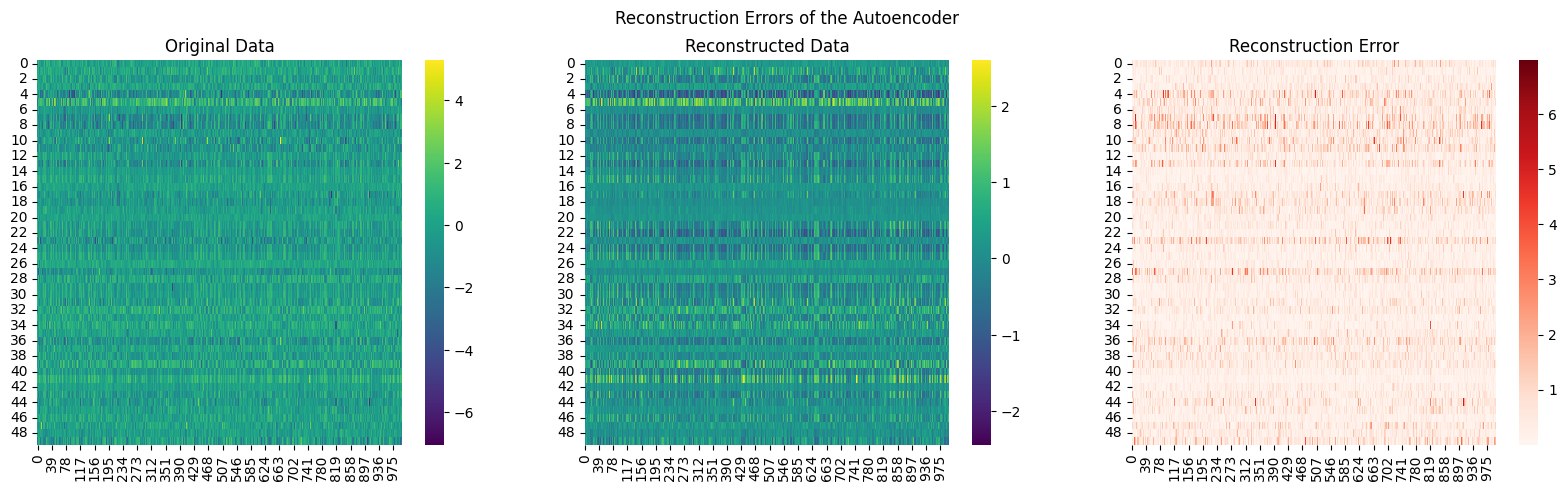

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the reconstructed data from the autoencoder
X_reconstructed = autoencoder.predict(meth_scaled)

# Calculate reconstruction errors (absolute difference between original and reconstructed data)
reconstruction_errors = np.abs(meth_scaled - X_reconstructed)

# Define a function to plot the combined heatmaps
def plot_combined_heatmaps(original, reconstructed, errors, title):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot the heatmap for the original data
    sns.heatmap(original[:50], ax=axes[0], cmap='viridis')
    axes[0].set_title('Original Data')
    
    # Plot the heatmap for the reconstructed data
    sns.heatmap(reconstructed[:50], ax=axes[1], cmap='viridis')
    axes[1].set_title('Reconstructed Data')
    
    # Plot the heatmap for the reconstruction error
    sns.heatmap(errors[:50], ax=axes[2], cmap='Reds')
    axes[2].set_title('Reconstruction Error')
    
    # Set the main title for the entire plot
    plt.suptitle(title)
    
    # Display the plot
    plt.show()

# Plot the heatmaps for the first 50 samples of each dataset
plot_combined_heatmaps(meth_scaled, X_reconstructed, reconstruction_errors, 'Reconstruction Errors of the Autoencoder')


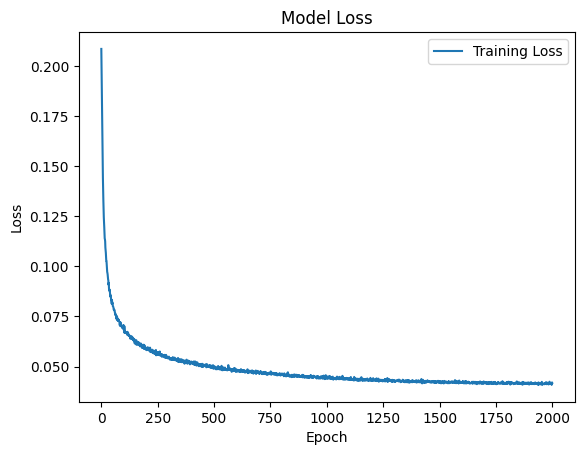

In [6]:
import matplotlib.pyplot as plt

def plot_loss(history):
    
    plt.plot(history.history['loss'], label='Training Loss')
   
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


plot_loss(history)


In [7]:
# Reconstruct the test data (using the trained autoencoder)
X_reconstructed = autoencoder.predict(meth_scaled)

# Convert the reconstructed data back to the original scale using the scaler
#X_reconstructed_original = scaler.inverse_transform(X_reconstructed)

# Save the reconstructed dataset to a CSV file
reconstructed_df = pd.DataFrame(X_reconstructed, columns=meth.columns)
reconstructed_df.to_csv('reconstructed_meth.csv', index=False)

print("Reconstructed dataset saved to 'reconstructed_meth.csv'.")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Reconstructed dataset saved to 'reconstructed_meth.csv'.


mRNA Trained 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import math

# Load the mRNA data
mRNA = pd.read_csv('mRNA.csv')

# Normalize the data
scaler = StandardScaler()
mRNA_scaled = scaler.fit_transform(mRNA)

# Define the autoencoder model
def create_denoising_autoencoder(input_dim, regularization=1e-6, dropout_rate=0.3, noise_factor=0.3):
    input_layer = Input(shape=(input_dim,))
    
    # Add Gaussian Noise for denoising
    noisy_input = GaussianNoise(noise_factor)(input_layer)
    
    # Encoder
    encoded = Dense(512, activation='relu', kernel_regularizer=l2(regularization))(noisy_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = Dense(64, activation='relu', activity_regularizer=l1(1e-5))(encoded)  # Sparse representation
    
    # Decoder
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    return autoencoder

# Define the autoencoder model
input_dim = mRNA_scaled.shape[1]
autoencoder = create_denoising_autoencoder(input_dim)

# Compile the autoencoder model with MSLE loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredLogarithmicError())

# Define the cosine annealing learning rate scheduler
def cosine_annealing(epoch, lr, initial_lr=0.0001, min_lr=1e-5, T=2000):
    """Cosine annealing learning rate schedule."""
    cos_inner = (math.pi * (epoch % T)) / T
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(cos_inner)) / 2

lr_schedule = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, T=2000))

# Train the autoencoder on the full mRNA dataset
history_mRNA = autoencoder.fit(
    mRNA_scaled, 
    mRNA_scaled, 
    epochs=2000, 
    batch_size=64, 
    callbacks=[lr_schedule]
)

# Print the final training loss
train_loss_mRNA = history_mRNA.history['loss'][-1]
print(f'Training loss for mRNA dataset: {train_loss_mRNA}')


Epoch 1/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2198 - learning_rate: 1.0000e-04
Epoch 2/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2114 - learning_rate: 1.0000e-04
Epoch 3/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2030 - learning_rate: 1.0000e-04
Epoch 4/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1981 - learning_rate: 1.0000e-04
Epoch 5/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1854 - learning_rate: 9.9999e-05
Epoch 6/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1784 - learning_rate: 9.9999e-05
Epoch 7/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1698 - learning_rate: 9.9998e-05
Epoch 8/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1641 - learning_rate: 9.9997e-05
Epoch 9/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1551 - learning_rate: 9.9996e-05
Epoch 10/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1467 - learning_rate: 9.9996e-05
Epoch 11/2000
14/14 ━━━━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


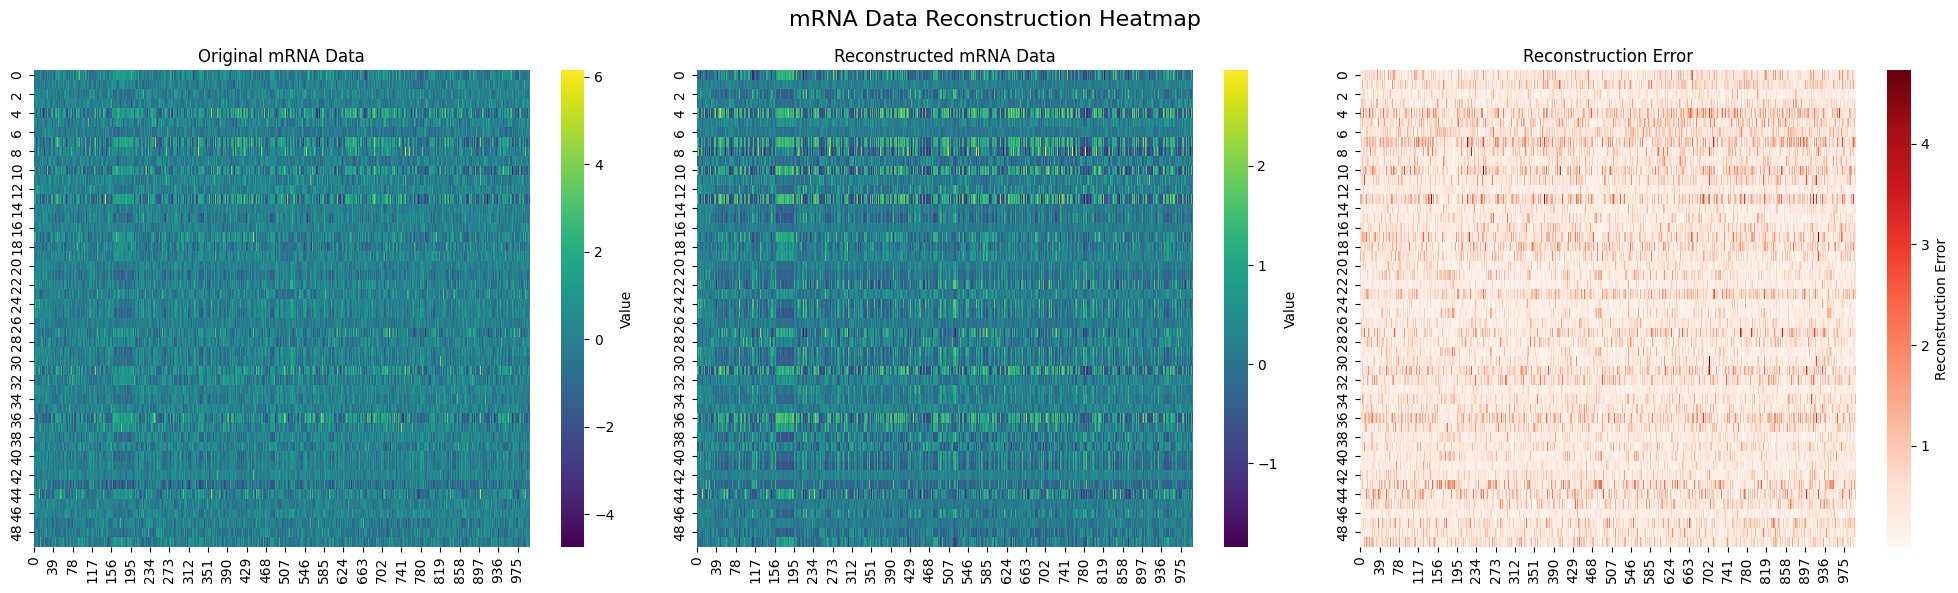

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct the data using the trained autoencoder
mRNA_reconstructed = autoencoder.predict(mRNA_scaled)

# Convert the reconstructed data back to the original scale
#mRNA_reconstructed_original = scaler.inverse_transform(mRNA_reconstructed)

# Calculate the reconstruction error (absolute error between original and reconstructed data)
reconstruction_error = np.abs(mRNA_scaled - mRNA_reconstructed)

def plot_combined_heatmaps(original, reconstructed, error, title):
    # Plot the first 50 samples for visualization (adjust as needed)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Heatmap for Original Data
    sns.heatmap(original[:50], ax=axes[0], cmap='viridis', cbar_kws={'label': 'Value'})
    axes[0].set_title('Original mRNA Data')

    # Heatmap for Reconstructed Data
    sns.heatmap(reconstructed[:50], ax=axes[1], cmap='viridis', cbar_kws={'label': 'Value'})
    axes[1].set_title('Reconstructed mRNA Data')

    # Heatmap for Reconstruction Error
    sns.heatmap(error[:50], ax=axes[2], cmap='Reds', cbar_kws={'label': 'Reconstruction Error'})
    axes[2].set_title('Reconstruction Error')

    # Overall title and layout adjustments
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot heatmaps for original, reconstructed data, and reconstruction error
plot_combined_heatmaps(mRNA_scaled, mRNA_reconstructed, reconstruction_error, 'mRNA Data Reconstruction Heatmap')


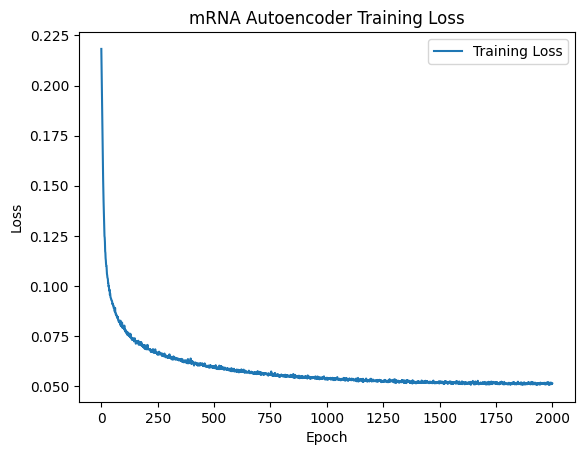

In [10]:
import matplotlib.pyplot as plt

def plot_loss_mRNA(history_mRNA):
    # Plot the training loss
    plt.plot(history_mRNA.history['loss'], label='Training Loss')

    plt.title('mRNA Autoencoder Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Plot the training loss for the mRNA dataset
plot_loss_mRNA(history_mRNA)


In [11]:
# Reconstruct the mRNA data using the trained autoencoder
mRNA_reconstructed = autoencoder.predict(mRNA_scaled)

# Convert the reconstructed data back to the original scale using the scaler
#mRNA_reconstructed_original = scaler.inverse_transform(mRNA_reconstructed)

# Save the reconstructed mRNA dataset to a CSV file
reconstructed_mRNA_df = pd.DataFrame(mRNA_reconstructed, columns=mRNA.columns)
reconstructed_mRNA_df.to_csv('reconstructed_mRNA.csv', index=False)

print("Reconstructed mRNA dataset saved to 'reconstructed_mRNA.csv'.")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Reconstructed mRNA dataset saved to 'reconstructed_mRNA.csv'.


miRNA 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import math

# Load the miRNA data
miRNA = pd.read_csv('miRNA.csv')

# Normalize the data
scaler_miRNA = StandardScaler()
miRNA_scaled = scaler_miRNA.fit_transform(miRNA)

# Define the autoencoder model
def create_denoising_autoencoder(input_dim, regularization=1e-6, dropout_rate=0.3, noise_factor=0.3):
    input_layer = Input(shape=(input_dim,))
    
    # Add Gaussian Noise for denoising
    noisy_input = GaussianNoise(noise_factor)(input_layer)
    
    # Encoder
    encoded = Dense(512, activation='relu', kernel_regularizer=l2(regularization))(noisy_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = Dense(64, activation='relu', activity_regularizer=l1(1e-5))(encoded)  # Sparse representation
    
    # Decoder
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    return autoencoder

# Define the autoencoder model
input_dim = miRNA_scaled.shape[1]
autoencoder_miRNA = create_denoising_autoencoder(input_dim)

# Compile the autoencoder model with MSLE loss
autoencoder_miRNA.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredLogarithmicError())

# Define the cosine annealing learning rate scheduler
def cosine_annealing(epoch, lr, initial_lr=0.0001, min_lr=1e-5, T=2000):
    """Cosine annealing learning rate schedule."""
    cos_inner = (math.pi * (epoch % T)) / T
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(cos_inner)) / 2

lr_schedule = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, T=2000))

# Train the autoencoder on the full dataset
history_miRNA = autoencoder_miRNA.fit(
    miRNA_scaled, 
    miRNA_scaled, 
    epochs=2000, 
    batch_size=64, 
    callbacks=[lr_schedule]
)

# Print the final training loss
train_loss_miRNA = history_miRNA.history['loss'][-1]  # Get the last training loss
print(f'Training loss for miRNA dataset: {train_loss_miRNA}')


Epoch 1/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2636 - learning_rate: 1.0000e-04
Epoch 2/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2554 - learning_rate: 1.0000e-04
Epoch 3/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2507 - learning_rate: 1.0000e-04
Epoch 4/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2453 - learning_rate: 1.0000e-04
Epoch 5/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2411 - learning_rate: 9.9999e-05
Epoch 6/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2366 - learning_rate: 9.9999e-05
Epoch 7/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2308 - learning_rate: 9.9998e-05
Epoch 8/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2261 - learning_rate: 9.9997e-05
Epoch 9/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2176 - learning_rate: 9.9996e-05
Epoch 10/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2159 - learning_rate: 9.9996e-05
Epoch 11/2000
14/14 ━━━━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


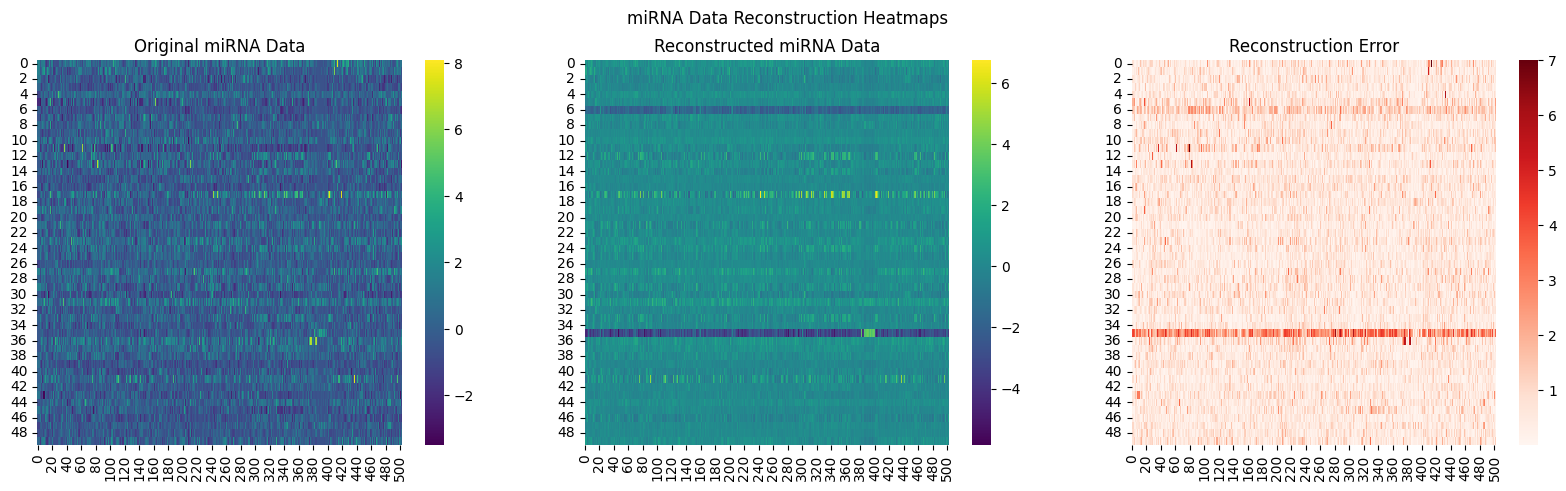

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct the miRNA data using the trained autoencoder
miRNA_reconstructed = autoencoder_miRNA.predict(miRNA_scaled)

# Convert the reconstructed data back to the original scale using the scaler
#miRNA_reconstructed_original = scaler_miRNA.inverse_transform(miRNA_reconstructed)

# Calculate the reconstruction errors
reconstruction_errors_miRNA = np.abs(miRNA_scaled - miRNA_reconstructed)

def plot_combined_heatmaps(original, reconstructed, errors, title):
    # Create a combined heatmap for original data, reconstructed data, and errors
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    sns.heatmap(original[:50], ax=axes[0], cmap='viridis', cbar=True)
    axes[0].set_title('Original miRNA Data')
    
    sns.heatmap(reconstructed[:50], ax=axes[1], cmap='viridis', cbar=True)
    axes[1].set_title('Reconstructed miRNA Data')
    
    sns.heatmap(errors[:50], ax=axes[2], cmap='Reds', cbar=True)
    axes[2].set_title('Reconstruction Error')
    
    plt.suptitle(title)
    plt.show()

# Plot the heatmaps for the miRNA dataset
plot_combined_heatmaps(miRNA_scaled, miRNA_reconstructed, reconstruction_errors_miRNA, 'miRNA Data Reconstruction Heatmaps')


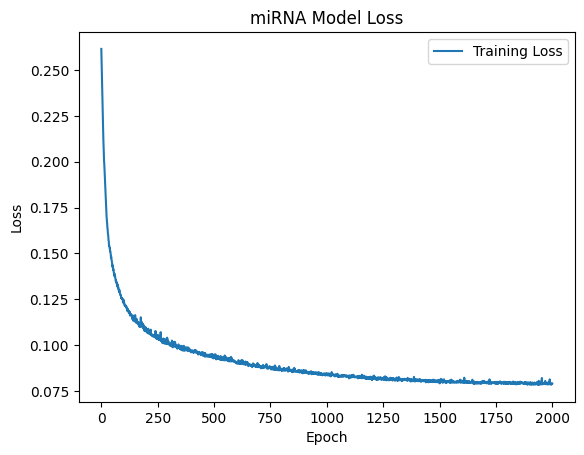

In [14]:
import matplotlib.pyplot as plt

def plot_loss_miRNA(history_miRNA):
    # Plot training loss
    plt.plot(history_miRNA.history['loss'], label='Training Loss')
   
    plt.title('miRNA Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Assuming history_miRNA is the variable holding the training history for miRNA
plot_loss_miRNA(history_miRNA)


In [15]:
# Reconstruct the test data for miRNA
X_test_reconstructed_miRNA = autoencoder_miRNA.predict(miRNA_scaled)

# Convert back to the original scale for miRNA
#X_test_reconstructed_original_miRNA = scaler_miRNA.inverse_transform(X_test_reconstructed_miRNA)

# Save the reconstructed dataset to a CSV file
reconstructed_miRNA_df = pd.DataFrame(X_test_reconstructed_miRNA, columns=miRNA.columns)
reconstructed_miRNA_df.to_csv('reconstructed_miRNA.csv', index=False)

print("Reconstructed dataset saved to 'reconstructed_miRNA.csv'.")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Reconstructed dataset saved to 'reconstructed_miRNA.csv'.


Concated Multiomics

Concatenated reconstruction dataset saved to 'concatenated_reconstruction_omics.csv'.


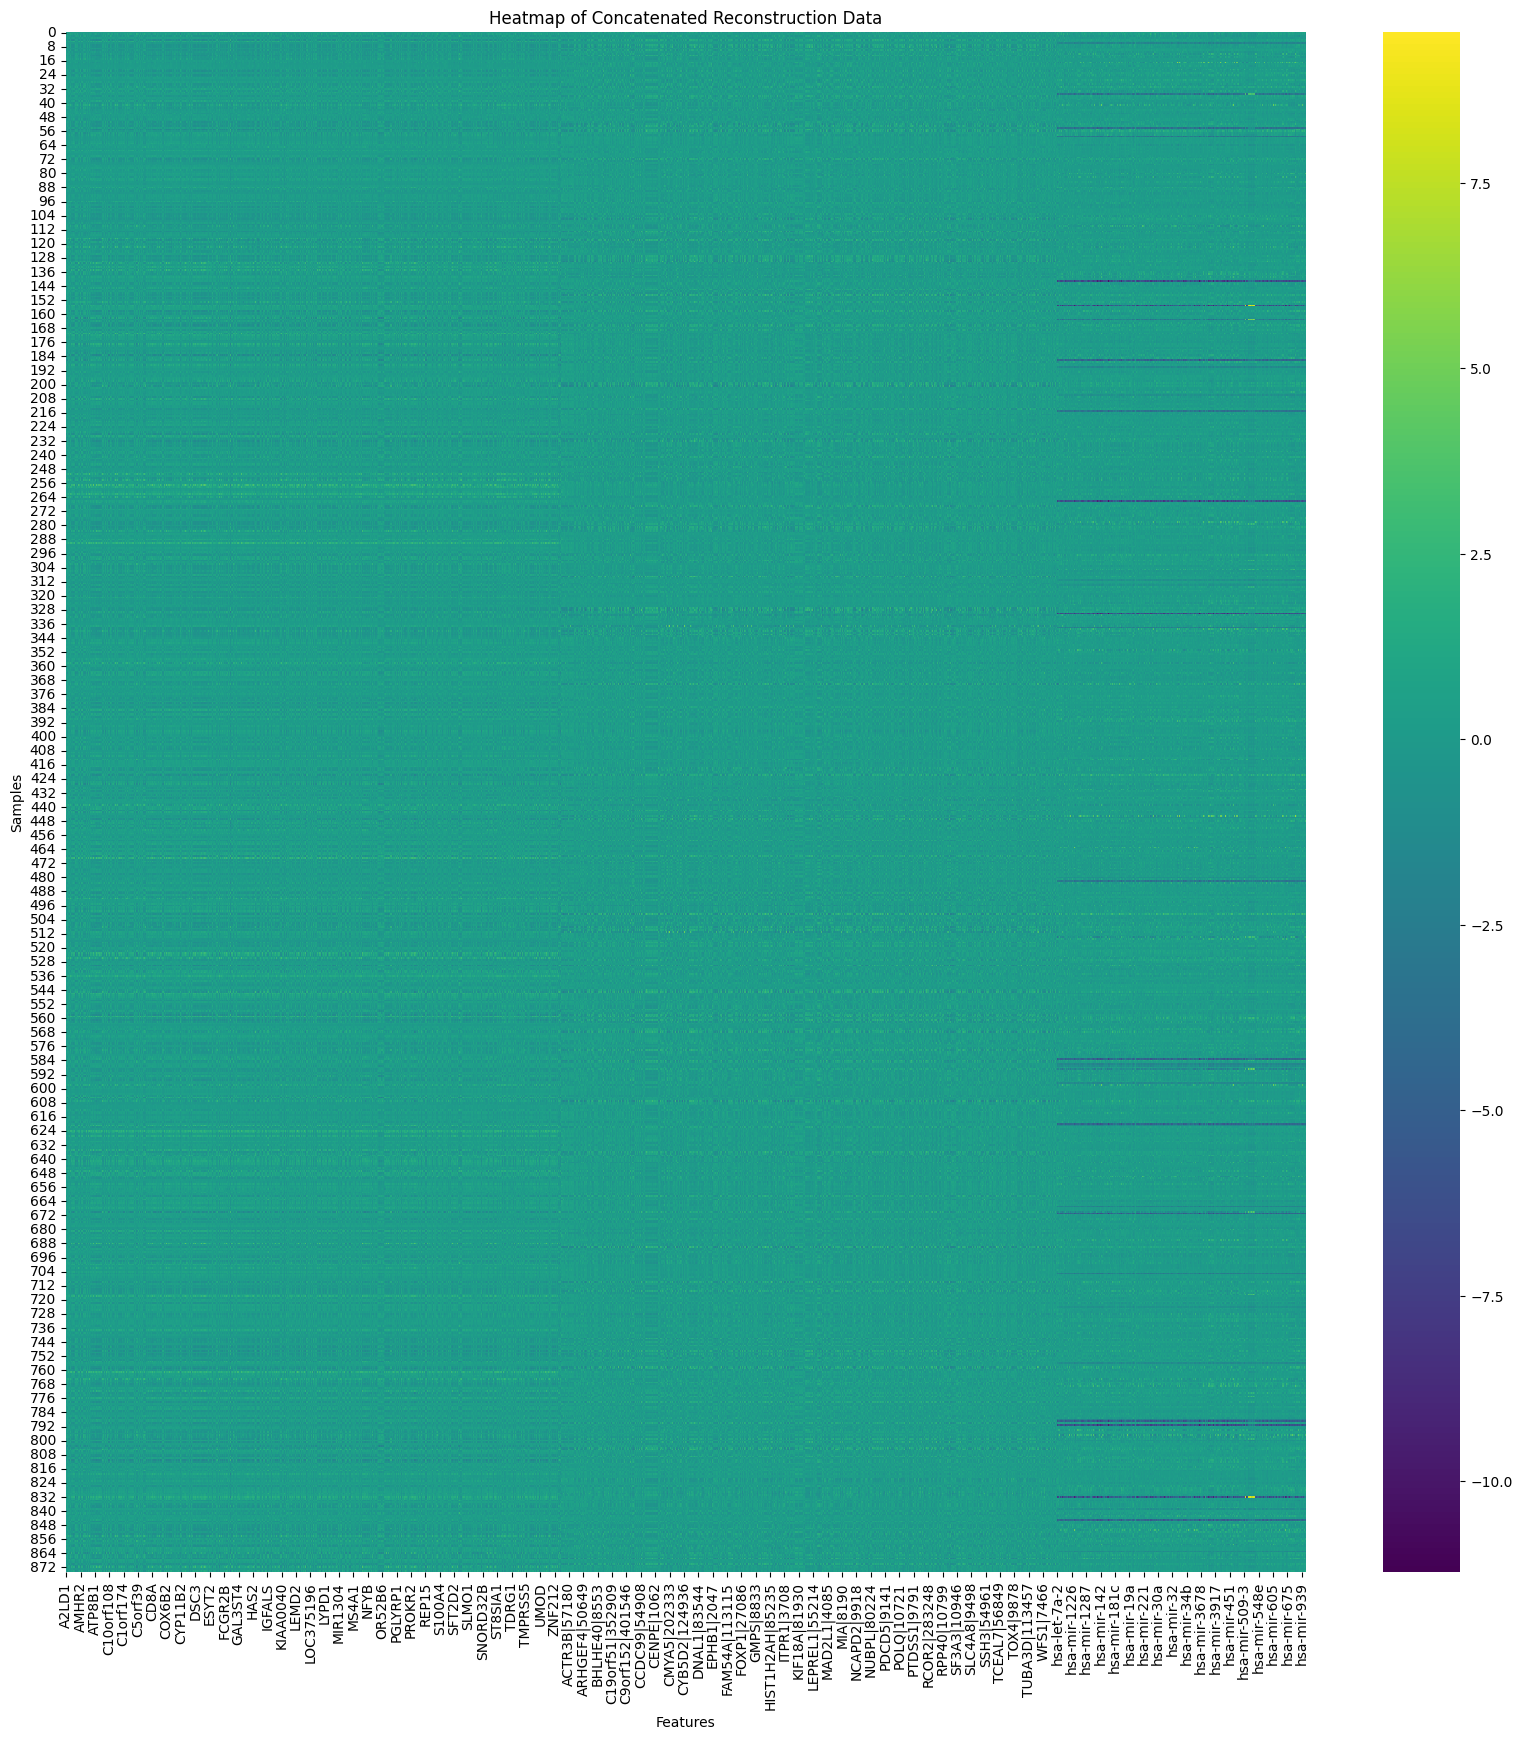

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate the reconstructed datasets
concatenated_reconstruction = pd.concat(
    [reconstructed_df, reconstructed_mRNA_df, reconstructed_miRNA_df],
    axis=1,
    #keys=["Meth", "mRNA", "miRNA"]
)

# Save the concatenated dataset to a CSV file
concatenated_reconstruction.to_csv("concatenated_reconstruction_omics.csv", index=False)
print("Concatenated reconstruction dataset saved to 'concatenated_reconstruction_omics.csv'.")

# Visualize the heatmap of the concatenated data (taking the first 2503 samples)
plt.figure(figsize=(20, 20))
sns.heatmap(concatenated_reconstruction.iloc[:2503], cmap="viridis")  # No transpose, features on x-axis, samples on y-axis
plt.title("Heatmap of Concatenated Reconstruction Data")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()


SMOTE + Neural Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb

# Load Data
data = pd.read_csv("concatenated_reconstruction_omics.csv").iloc[1:]  # Skip the first row
labels = pd.read_csv("labels.csv")

# Align data and labels
if data.shape[0] > labels.shape[0]:
    data = data.iloc[:labels.shape[0], :]
elif labels.shape[0] > data.shape[0]:
    labels = labels.iloc[:data.shape[0], :]

# Encode Labels
labels_encoded = LabelEncoder().fit_transform(labels.values.ravel())

# Standardize Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
# label repetation ....


# Balance Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_scaled, labels_encoded)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert Labels to One-Hot Encoding for Neural Network
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Neural Network Model
def build_nn_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, input_dim=input_dim, activation='relu', kernel_regularizer='l2'),
        Dropout(0.1),
        Dense(256, activation='relu', kernel_regularizer='l2'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

nn_model = build_nn_model(X_train.shape[1], len(np.unique(labels_encoded)))

# Early Stopping Callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train Neural Network
history = nn_model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    epochs=1000,
    batch_size=256,
    verbose=1,
    #callbacks=[early_stopping]
)

# Evaluate Neural Network
y_test_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_test_pred_nn))



Epoch 1/1000


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5440 - loss: 13.0672 - val_accuracy: 0.8096 - val_loss: 11.6832
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7694 - loss: 11.5712 - val_accuracy: 0.8142 - val_loss: 10.5189
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7844 - loss: 10.2663 - val_accuracy: 0.8280 - val_loss: 9.2458
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8278 - loss: 8.9608 - val_accuracy: 0.8280 - val_loss: 8.0921
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8285 - loss: 7.8491 - val_accuracy: 0.8188 - val_loss: 7.0563
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8484 - loss: 6.7568 - val_accuracy: 0.8578 - val_loss: 6.0718
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8627 - loss: 5.8585 - val_accuracy: 0.8670 - val_loss: 5.2456
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8632 - loss: 5.0631 - val_accuracy: 0.8601 - val_loss:

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


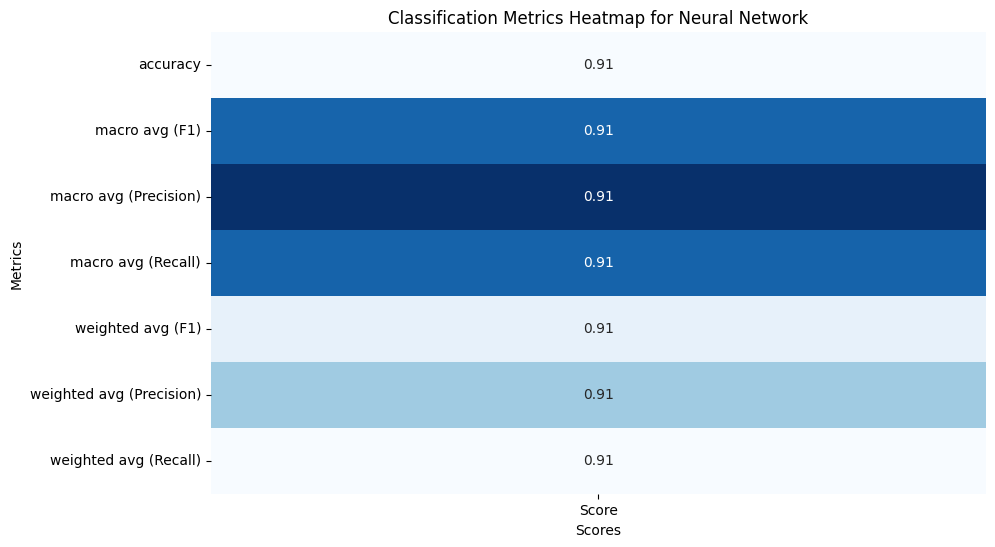

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate predictions for the test set
y_test_pred_classes = np.argmax(nn_model.predict(X_test), axis=1)

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_test_pred_classes, output_dict=True)

# Extract relevant metrics
metrics = {
    "accuracy": report_dict["accuracy"],
    "macro avg (F1)": report_dict["macro avg"]["f1-score"],
    "macro avg (Precision)": report_dict["macro avg"]["precision"],
    "macro avg (Recall)": report_dict["macro avg"]["recall"],
    "weighted avg (F1)": report_dict["weighted avg"]["f1-score"],
    "weighted avg (Precision)": report_dict["weighted avg"]["precision"],
    "weighted avg (Recall)": report_dict["weighted avg"]["recall"]
}

# Convert metrics to a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Score"]).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Metrics Heatmap for Neural Network")
plt.ylabel("Metrics")
plt.xlabel("Scores")
plt.show()


NN with OPTUNA

In [1]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import optuna
from tensorflow.keras.utils import to_categorical

# Step 1: Load and Preprocess Data
data = pd.read_csv("concatenated_reconstruction_omics.csv").iloc[1:]  # Skip the first row
labels = pd.read_csv("labels.csv")

# Align data and labels
if data.shape[0] > labels.shape[0]:
    data = data.iloc[:labels.shape[0], :]
elif labels.shape[0] > data.shape[0]:
    labels = labels.iloc[:data.shape[0], :]

# Encode labels
labels_encoded = LabelEncoder().fit_transform(labels.values.ravel())

# Standardize Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Balance Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_scaled, labels_encoded)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert Labels to One-Hot Encoding for Neural Network
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Step 2: Define Objective Function for Optuna
def objective(trial):
    # Hyperparameter suggestions
    num_layers = trial.suggest_int('num_layers', 2, 4)  # Number of layers
    layer_units = trial.suggest_int('layer_units', 128, 512, step=64)  # Neurons per layer
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)  # Dropout
    batch_size = trial.suggest_int('batch_size', 64, 512, step=64)  # Batch size
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Learning rate
    
    # Build Model
    model = Sequential()
    model.add(Dense(layer_units, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):  # Add additional layers
        model.add(Dense(layer_units, activation='relu', kernel_regularizer='l2'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))
    
    # Compile Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train Model with Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train_one_hot,
        validation_data=(X_test, y_test_one_hot),
        epochs=2000,
        batch_size=batch_size,
        verbose=0,  # Suppress training output for Optuna
        callbacks=[early_stopping]
    )
    
    # Evaluate on Validation Set
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Optuna maximizes this value

# Step 3: Run Optuna Study
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 5 trials

# Best Hyperparameters
print("Best hyperparameters:", study.best_params)

# Step 4: Train Final Model with Best Hyperparameters
best_params = study.best_params
final_model = Sequential()
final_model.add(Dense(best_params['layer_units'], input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))
final_model.add(Dropout(best_params['dropout_rate']))
for _ in range(best_params['num_layers'] - 1):
    final_model.add(Dense(best_params['layer_units'], activation='relu', kernel_regularizer='l2'))
    final_model.add(Dropout(best_params['dropout_rate']))
final_model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    epochs=2000,
    batch_size=best_params['batch_size'],
    verbose=1
)

# Step 5: Evaluate Final Model
y_final_pred = np.argmax(final_model.predict(X_test), axis=1)
print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_final_pred))


[I 2024-12-09 18:10:05,555] A new study created in memory with name: no-name-fcdfc3c3-9a5c-4c83-81d7-8dafe318301f
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:10:34,451] Trial 0 finished with value: 0.8669724770642202 and parameters: {'num_layers': 4, 'layer_units': 384, 'dropout_rate': 0.2, 'batch_size': 128, 'learning_rate': 0.0002193587143236872}. Best is trial 0 with value: 0.8669724770642202.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-12-09 18:10:57,421] Trial 1 finished with value: 0.8715596330275229 and parameters: {'num_layers': 2, 'layer_units': 320, 'dropout_rate': 0.2, 'batch_size': 128, 'learning_rate': 0.005037862536911192}. Best is trial 1 with value: 0.8715596330275229.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:11:24,522] Trial 2 finished with value: 0.8646788990825688 and parameters: {'num_layers': 4, 'layer_units': 384, 'dropout_rate': 0.5, 'batch_size': 384, 'learning_rate': 0.0011999218383790897}. Best is trial 1 with value: 0.8715596330275229.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:11:49,566] Trial 3 finished with value: 0.8509174311926605 and parameters: {'num_layers': 4, 'layer_units': 192, 'dropout_rate': 0.5, 'batch_size': 192, 'learning_rate': 0.00010924185512698346}. Best is trial 1 with value: 0.8715596330275229.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-12-09 18:12:10,281] Trial 4 finished with value: 0.8922018348623854 and parameters: {'num_layers': 2, 'layer_units': 192, 'dropout_rate': 0.4, 'batch_size': 512, 'learning_rate': 0.00015745505969781196}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:12:36,237] Trial 5 finished with value: 0.8784403669724771 and parameters: {'num_layers': 4, 'layer_units': 320, 'dropout_rate': 0.5, 'batch_size': 512, 'learning_rate': 0.0057632899885960215}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-12-09 18:13:11,512] Trial 6 finished with value: 0.8669724770642202 and parameters: {'num_layers': 4, 'layer_units': 512, 'dropout_rate': 0.30000000000000004, 'batch_size': 128, 'learning_rate': 0.0001124163161211661}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:13:30,933] Trial 7 finished with value: 0.8853211009174312 and parameters: {'num_layers': 3, 'layer_units': 320, 'dropout_rate': 0.2, 'batch_size': 256, 'learning_rate': 0.0025016548746120268}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:13:49,097] Trial 8 finished with value: 0.8761467889908257 and parameters: {'num_layers': 4, 'layer_units': 192, 'dropout_rate': 0.2, 'batch_size': 256, 'learning_rate': 0.00015230848610090346}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-12-09 18:14:20,994] Trial 9 finished with value: 0.8922018348623854 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.1, 'batch_size': 448, 'learning_rate': 0.0015217779448991606}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-12-09 18:14:35,642] Trial 10 finished with value: 0.8623853211009175 and parameters: {'num_layers': 2, 'layer_units': 128, 'dropout_rate': 0.4, 'batch_size': 384, 'learning_rate': 0.0005154828060525342}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2024-12-09 18:15:21,829] Trial 11 finished with value: 0.8922018348623854 and parameters: {'num_layers': 3, 'layer_units': 512, 'dropout_rate': 0.1, 'batch_size': 512, 'learning_rate': 0.0005809336630343221}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-12-09 18:15:50,416] Trial 12 finished with value: 0.8715596330275229 and parameters: {'num_layers': 2, 'layer_units': 448, 'dropout_rate': 0.4, 'batch_size': 384, 'learning_rate': 0.001280392005944654}. Best is trial 4 with value: 0.8922018348623854.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-12-09 18:16:09,909] Trial 13 finished with value: 0.8967889908256881 and parameters: {'num_layers': 3, 'layer_units': 192, 'dropout_rate': 0.1, 'batch_size': 448, 'learning_rate': 0.0003805738899664983}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-12-09 18:16:26,072] Trial 14 finished with value: 0.8899082568807339 and parameters: {'num_layers': 2, 'layer_units': 192, 'dropout_rate': 0.4, 'batch_size': 448, 'learning_rate': 0.00033774151539851224}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-12-09 18:16:46,418] Trial 15 finished with value: 0.8922018348623854 and parameters: {'num_layers': 3, 'layer_units': 128, 'dropout_rate': 0.30000000000000004, 'batch_size': 512, 'learning_rate': 0.0002705043314254969}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-12-09 18:17:08,767] Trial 16 finished with value: 0.8623853211009175 and parameters: {'num_layers': 2, 'layer_units': 256, 'dropout_rate': 0.4, 'batch_size': 320, 'learning_rate': 0.0005521489159188129}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:17:34,904] Trial 17 finished with value: 0.8922018348623854 and parameters: {'num_layers': 3, 'layer_units': 256, 'dropout_rate': 0.30000000000000004, 'batch_size': 448, 'learning_rate': 0.0003463962901553787}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-12-09 18:17:58,773] Trial 18 finished with value: 0.8830275229357798 and parameters: {'num_layers': 3, 'layer_units': 256, 'dropout_rate': 0.1, 'batch_size': 320, 'learning_rate': 0.00019717342776296156}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-12-09 18:18:13,821] Trial 19 finished with value: 0.8899082568807339 and parameters: {'num_layers': 2, 'layer_units': 128, 'dropout_rate': 0.4, 'batch_size': 448, 'learning_rate': 0.0007133496839142258}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-12-09 18:18:42,789] Trial 20 finished with value: 0.8463302752293578 and parameters: {'num_layers': 3, 'layer_units': 192, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'learning_rate': 0.0023483866405892835}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-12-09 18:19:25,287] Trial 21 finished with value: 0.8967889908256881 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.1, 'batch_size': 448, 'learning_rate': 0.0020916757156225606}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-12-09 18:19:53,652] Trial 22 finished with value: 0.8853211009174312 and parameters: {'num_layers': 3, 'layer_units': 384, 'dropout_rate': 0.1, 'batch_size': 512, 'learning_rate': 0.003282834570648396}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:20:18,360] Trial 23 finished with value: 0.8784403669724771 and parameters: {'num_layers': 3, 'layer_units': 256, 'dropout_rate': 0.1, 'batch_size': 384, 'learning_rate': 0.008484526361292063}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-12-09 18:20:48,384] Trial 24 finished with value: 0.8944954128440367 and parameters: {'num_layers': 2, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.00015349986141193218}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:21:22,865] Trial 25 finished with value: 0.8784403669724771 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 320, 'learning_rate': 0.0009166320244472313}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2024-12-09 18:21:50,568] Trial 26 finished with value: 0.8807339449541285 and parameters: {'num_layers': 2, 'layer_units': 512, 'dropout_rate': 0.1, 'batch_size': 448, 'learning_rate': 0.00040077571108019155}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:22:15,070] Trial 27 finished with value: 0.8967889908256881 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 384, 'learning_rate': 0.0007981995889665214}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:22:40,629] Trial 28 finished with value: 0.8922018348623854 and parameters: {'num_layers': 3, 'layer_units': 384, 'dropout_rate': 0.1, 'batch_size': 384, 'learning_rate': 0.0018975113561943797}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:23:11,924] Trial 29 finished with value: 0.8853211009174312 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 320, 'learning_rate': 0.0008429679007787246}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:23:33,332] Trial 30 finished with value: 0.8692660550458715 and parameters: {'num_layers': 3, 'layer_units': 384, 'dropout_rate': 0.1, 'batch_size': 384, 'learning_rate': 0.0037880591607202894}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:24:03,240] Trial 31 finished with value: 0.8899082568807339 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.0002287258856977911}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2024-12-09 18:24:36,286] Trial 32 finished with value: 0.8899082568807339 and parameters: {'num_layers': 2, 'layer_units': 512, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.0004419958087737587}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2024-12-09 18:25:00,619] Trial 33 finished with value: 0.8807339449541285 and parameters: {'num_layers': 4, 'layer_units': 384, 'dropout_rate': 0.2, 'batch_size': 384, 'learning_rate': 0.001113274666651202}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:25:30,291] Trial 34 finished with value: 0.8944954128440367 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.0007369098979801305}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-12-09 18:26:01,998] Trial 35 finished with value: 0.8876146788990825 and parameters: {'num_layers': 4, 'layer_units': 448, 'dropout_rate': 0.1, 'batch_size': 512, 'learning_rate': 0.00027684910271956594}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:26:30,139] Trial 36 finished with value: 0.8738532110091743 and parameters: {'num_layers': 3, 'layer_units': 320, 'dropout_rate': 0.1, 'batch_size': 384, 'learning_rate': 0.00015365335313007882}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-12-09 18:27:13,292] Trial 37 finished with value: 0.8830275229357798 and parameters: {'num_layers': 4, 'layer_units': 512, 'dropout_rate': 0.30000000000000004, 'batch_size': 512, 'learning_rate': 0.0016213354442978424}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-12-09 18:27:33,271] Trial 38 finished with value: 0.8899082568807339 and parameters: {'num_layers': 2, 'layer_units': 384, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.00010596464969701387}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-12-09 18:27:53,048] Trial 39 finished with value: 0.8807339449541285 and parameters: {'num_layers': 2, 'layer_units': 320, 'dropout_rate': 0.2, 'batch_size': 256, 'learning_rate': 0.00018473979440399282}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2024-12-09 18:28:22,153] Trial 40 finished with value: 0.8532110091743119 and parameters: {'num_layers': 4, 'layer_units': 512, 'dropout_rate': 0.1, 'batch_size': 192, 'learning_rate': 0.002177153683520339}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:28:48,019] Trial 41 finished with value: 0.8853211009174312 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.0007312170507646586}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-12-09 18:29:13,720] Trial 42 finished with value: 0.8853211009174312 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.0012249123216796353}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2024-12-09 18:29:41,346] Trial 43 finished with value: 0.8830275229357798 and parameters: {'num_layers': 3, 'layer_units': 384, 'dropout_rate': 0.30000000000000004, 'batch_size': 512, 'learning_rate': 0.0006654766831651845}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:30:14,122] Trial 44 finished with value: 0.8807339449541285 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.1, 'batch_size': 384, 'learning_rate': 0.0009525489007827843}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-12-09 18:30:48,361] Trial 45 finished with value: 0.8807339449541285 and parameters: {'num_layers': 3, 'layer_units': 512, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.0031215636562045125}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-12-09 18:31:20,168] Trial 46 finished with value: 0.8899082568807339 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.2, 'batch_size': 512, 'learning_rate': 0.0015163601803499015}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-12-09 18:31:43,664] Trial 47 finished with value: 0.8876146788990825 and parameters: {'num_layers': 3, 'layer_units': 320, 'dropout_rate': 0.1, 'batch_size': 384, 'learning_rate': 0.000429403520980572}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-12-09 18:32:07,345] Trial 48 finished with value: 0.8876146788990825 and parameters: {'num_layers': 4, 'layer_units': 384, 'dropout_rate': 0.2, 'batch_size': 448, 'learning_rate': 0.0005300413801061076}. Best is trial 13 with value: 0.8967889908256881.
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-12-09 18:32:29,365] Trial 49 finished with value: 0.8807339449541285 and parameters: {'num_layers': 3, 'layer_units': 448, 'dropout_rate': 0.30000000000000004, 'batch_size': 320, 'learning_rate': 0.0001334751318691076}. Best is trial 13 with value: 0.8967889908256881.


Best hyperparameters: {'num_layers': 3, 'layer_units': 192, 'dropout_rate': 0.1, 'batch_size': 448, 'learning_rate': 0.0003805738899664983}
Epoch 1/1000


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.3917 - loss: 8.7919 - val_accuracy: 0.7546 - val_loss: 7.8204
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7730 - loss: 7.7566 - val_accuracy: 0.7982 - val_loss: 7.3849
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7965 - loss: 7.3220 - val_accuracy: 0.8165 - val_loss: 6.9292
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8095 - loss: 6.8780 - val_accuracy: 0.8257 - val_loss: 6.5148
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8294 - loss: 6.4238 - val_accuracy: 0.8257 - val_loss: 6.1115
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8331 - loss: 6.0283 - val_accuracy: 0.8303 - val_loss: 5.7114
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8366 - loss: 5.6269 - val_accuracy: 0.8486 - val_loss: 5.3203
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8504 - loss: 5.2298 - val_accuracy: 0.8486 - val_loss: 4.9

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


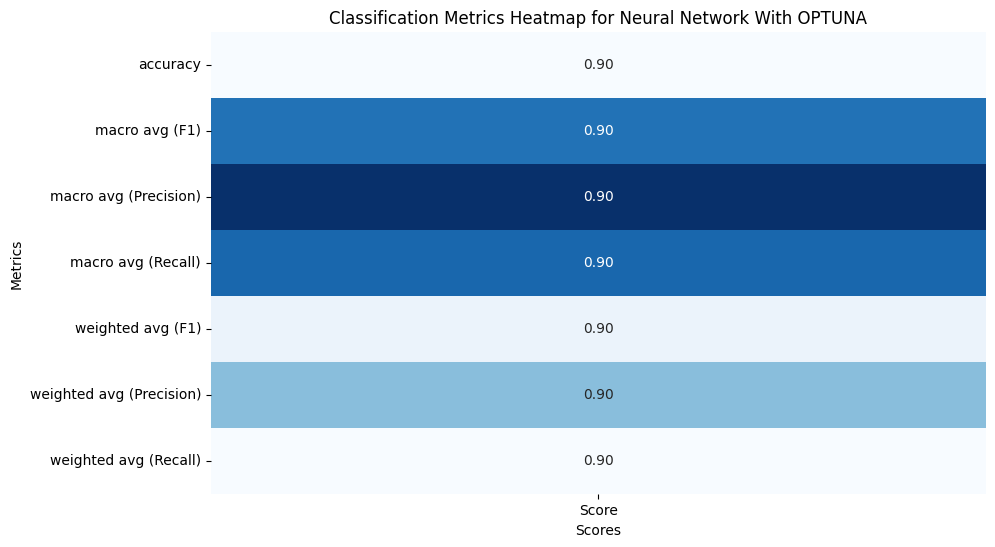

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate predictions for the test set
y_test_pred_classes = np.argmax(final_model.predict(X_test), axis=1)

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_test_pred_classes, output_dict=True)

# Extract relevant metrics
metrics = {
    "accuracy": report_dict["accuracy"],
    "macro avg (F1)": report_dict["macro avg"]["f1-score"],
    "macro avg (Precision)": report_dict["macro avg"]["precision"],
    "macro avg (Recall)": report_dict["macro avg"]["recall"],
    "weighted avg (F1)": report_dict["weighted avg"]["f1-score"],
    "weighted avg (Precision)": report_dict["weighted avg"]["precision"],
    "weighted avg (Recall)": report_dict["weighted avg"]["recall"]
}

# Convert metrics to a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Score"]).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Metrics Heatmap for Neural Network With OPTUNA")
plt.ylabel("Metrics")
plt.xlabel("Scores")
plt.show()


SVM

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load Data
data = pd.read_csv("concatenated_reconstruction_omics.csv").iloc[1:]  # Skip the first row
labels = pd.read_csv("labels.csv")

# Align data and labels
if data.shape[0] > labels.shape[0]:
    data = data.iloc[:labels.shape[0], :]
elif labels.shape[0] > data.shape[0]:
    labels = labels.iloc[:data.shape[0], :]

# Encode Labels
labels_encoded = LabelEncoder().fit_transform(labels.values.ravel())

# Standardize Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Balance Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_scaled, labels_encoded)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train an SVM Model
svm_model = SVC(kernel='linear', random_state=42, probability=True)
svm_model.fit(X_train, y_train)

# Make Predictions with SVM
y_test_pred_svm = svm_model.predict(X_test)

# Evaluate SVM Model
print("\nClassification Report for SVM:")
print(classification_report(y_test, y_test_pred_svm))

# Optional: Print Accuracy
accuracy = accuracy_score(y_test, y_test_pred_svm)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")



Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        93
           1       0.95      0.97      0.96        91
           2       0.97      1.00      0.99        74
           3       0.89      0.81      0.85        86
           4       0.87      0.87      0.87        92

    accuracy                           0.89       436
   macro avg       0.90      0.90      0.90       436
weighted avg       0.89      0.89      0.89       436

SVM Accuracy: 89.45%


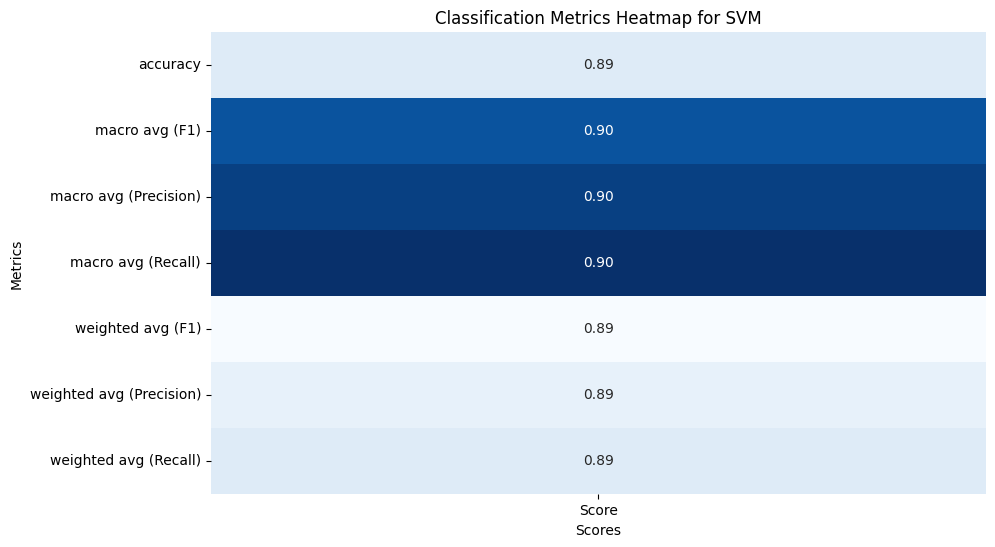

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate predictions for the test set
y_test_pred_classes = svm_model.predict(X_test)  # Directly use predictions

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_test_pred_classes, output_dict=True)

# Extract relevant metrics
metrics = {
    "accuracy": report_dict["accuracy"],
    "macro avg (F1)": report_dict["macro avg"]["f1-score"],
    "macro avg (Precision)": report_dict["macro avg"]["precision"],
    "macro avg (Recall)": report_dict["macro avg"]["recall"],
    "weighted avg (F1)": report_dict["weighted avg"]["f1-score"],
    "weighted avg (Precision)": report_dict["weighted avg"]["precision"],
    "weighted avg (Recall)": report_dict["weighted avg"]["recall"]
}

# Convert metrics to a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Score"]).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Metrics Heatmap for SVM")
plt.ylabel("Metrics")
plt.xlabel("Scores")
plt.show()


SMOTE + CNN

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Load Data
data = pd.read_csv("concatenated_reconstruction_omics.csv").iloc[1:]  # Skip the first row
labels = pd.read_csv("labels.csv")

# Align data and labels
if data.shape[0] > labels.shape[0]:
    data = data.iloc[:labels.shape[0], :]
elif labels.shape[0] > data.shape[0]:
    labels = labels.iloc[:data.shape[0], :]

# Encode Labels
labels_encoded = LabelEncoder().fit_transform(labels.values.ravel())

# Standardize Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Balance Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_scaled, labels_encoded)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape data for CNN (adding a channel dimension)
X_train_cnn = np.expand_dims(X_train, axis=2)  # Reshape to (samples, features, 1)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Convert Labels to One-Hot Encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# CNN Model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.01),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.01),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer='l2'),
        Dropout(0.01),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model((X_train_cnn.shape[1], X_train_cnn.shape[2]), len(np.unique(labels_encoded)))

# Train CNN
history = cnn_model.fit(
    X_train_cnn, y_train_one_hot,
    validation_data=(X_test_cnn, y_test_one_hot),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaluate CNN
y_test_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
print("\nClassification Report for CNN:")
print(classification_report(y_test, y_test_pred_cnn))


Epoch 1/10


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3417 - loss: 7.1945 - val_accuracy: 0.5963 - val_loss: 4.0618
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6536 - loss: 3.8241 - val_accuracy: 0.8028 - val_loss: 3.1306
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8105 - loss: 2.9206 - val_accuracy: 0.8119 - val_loss: 2.3682
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8315 - loss: 2.1493 - val_accuracy: 0.8165 - val_loss: 1.7769
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8419 - loss: 1.6374 - val_accuracy: 0.8349 - val_loss: 1.3835
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8532 - loss: 1.2892 - val_accuracy: 0.8440 - val_loss: 1.0911
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8556 - loss: 1.0013 - val_accuracy: 0.8532 - val_loss: 0.9305
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8637 - loss: 0.8672 - val_accuracy: 0.8211 - val_loss: 0.8268
Epoch 9/10
7/7 ━━━━

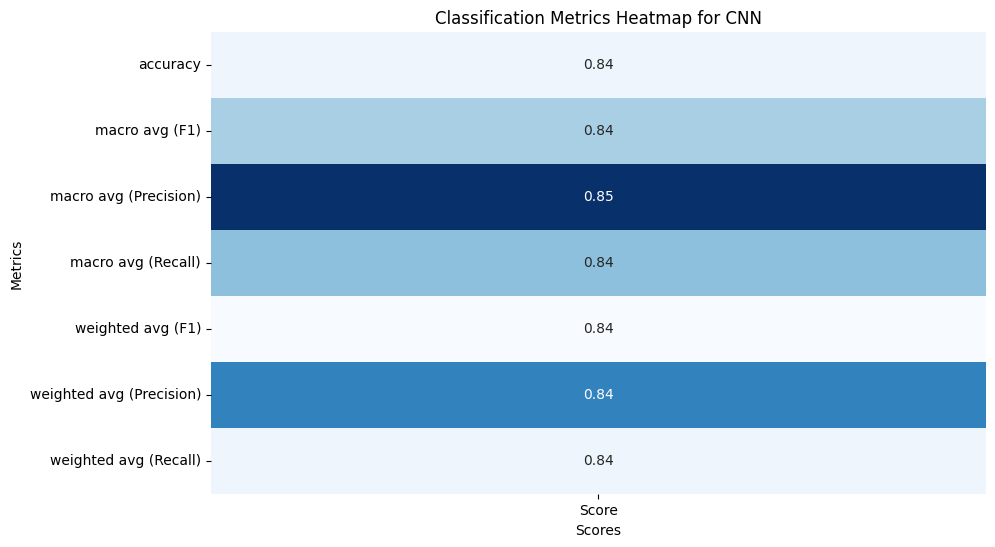

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report


report_dict = classification_report(y_test, y_test_pred_cnn, output_dict=True)

# Extract relevant metrics
metrics = {
    "accuracy": report_dict["accuracy"],
    "macro avg (F1)": report_dict["macro avg"]["f1-score"],
    "macro avg (Precision)": report_dict["macro avg"]["precision"],
    "macro avg (Recall)": report_dict["macro avg"]["recall"],
    "weighted avg (F1)": report_dict["weighted avg"]["f1-score"],
    "weighted avg (Precision)": report_dict["weighted avg"]["precision"],
    "weighted avg (Recall)": report_dict["weighted avg"]["recall"]
}

# Convert metrics to a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Score"]).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Metrics Heatmap for CNN")
plt.ylabel("Metrics")
plt.xlabel("Scores")
plt.show()


RandomForestClassifier

In [56]:
# Random Forest Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb

# Load Data
data = pd.read_csv("concatenated_reconstruction_omics.csv").iloc[1:]  # Skip the first row
labels = pd.read_csv("labels.csv")

# Align data and labels
if data.shape[0] > labels.shape[0]:
    data = data.iloc[:labels.shape[0], :]
elif labels.shape[0] > data.shape[0]:
    labels = labels.iloc[:data.shape[0], :]

# Encode Labels
labels_encoded = LabelEncoder().fit_transform(labels.values.ravel())

# Standardize Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Balance Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_scaled, labels_encoded)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
rf_model.fit(X_train, y_train)

y_test_pred_rf = rf_model.predict(X_test)
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_test_pred_rf))




Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        93
           1       0.97      0.97      0.97        91
           2       0.99      0.95      0.97        74
           3       0.85      0.81      0.83        86
           4       0.87      0.87      0.87        92

    accuracy                           0.88       436
   macro avg       0.89      0.88      0.89       436
weighted avg       0.89      0.88      0.88       436



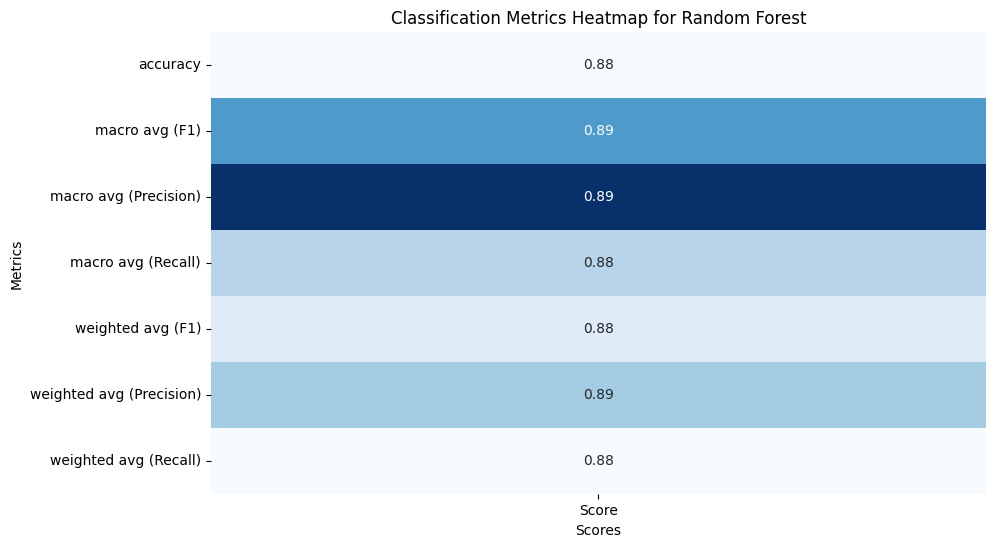

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report


report_dict = classification_report(y_test, y_test_pred_rf, output_dict=True)

# Extract relevant metrics
metrics = {
    "accuracy": report_dict["accuracy"],
    "macro avg (F1)": report_dict["macro avg"]["f1-score"],
    "macro avg (Precision)": report_dict["macro avg"]["precision"],
    "macro avg (Recall)": report_dict["macro avg"]["recall"],
    "weighted avg (F1)": report_dict["weighted avg"]["f1-score"],
    "weighted avg (Precision)": report_dict["weighted avg"]["precision"],
    "weighted avg (Recall)": report_dict["weighted avg"]["recall"]
}

# Convert metrics to a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Score"]).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Metrics Heatmap for Random Forest")
plt.ylabel("Metrics")
plt.xlabel("Scores")
plt.show()


XGBoostClassifier

In [58]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_test_pred_xgb = xgb_model.predict(X_test)
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_test_pred_xgb))



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        93
           1       0.96      0.99      0.97        91
           2       0.99      0.96      0.97        74
           3       0.84      0.78      0.81        86
           4       0.87      0.88      0.88        92

    accuracy                           0.88       436
   macro avg       0.89      0.89      0.89       436
weighted avg       0.88      0.88      0.88       436



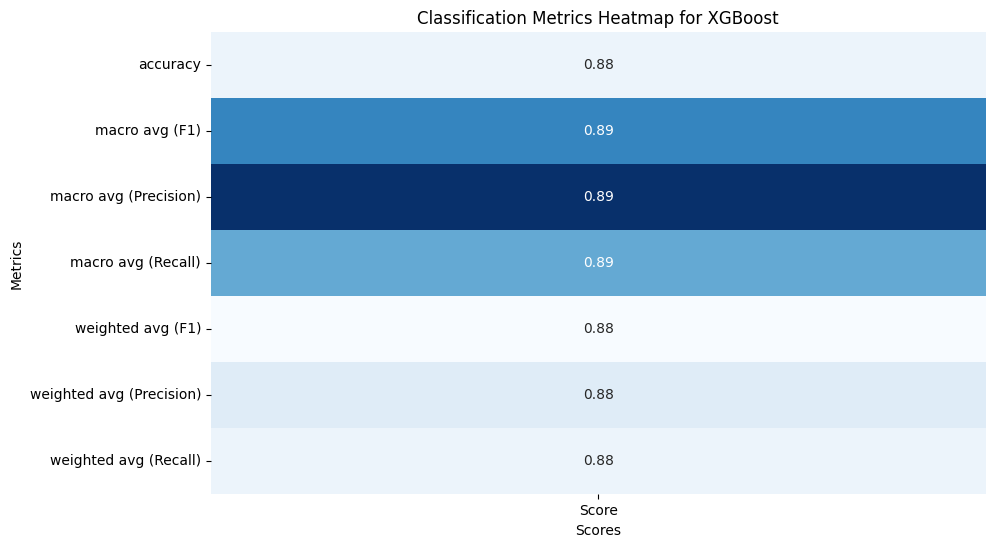

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report


report_dict = classification_report(y_test, y_test_pred_xgb, output_dict=True)

# Extract relevant metrics
metrics = {
    "accuracy": report_dict["accuracy"],
    "macro avg (F1)": report_dict["macro avg"]["f1-score"],
    "macro avg (Precision)": report_dict["macro avg"]["precision"],
    "macro avg (Recall)": report_dict["macro avg"]["recall"],
    "weighted avg (F1)": report_dict["weighted avg"]["f1-score"],
    "weighted avg (Precision)": report_dict["weighted avg"]["precision"],
    "weighted avg (Recall)": report_dict["weighted avg"]["recall"]
}

# Convert metrics to a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Score"]).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Metrics Heatmap for XGBoost")
plt.ylabel("Metrics")
plt.xlabel("Scores")
plt.show()
